**A sample notebook to predict stock prices using multiple regression methods**

**Import dependencies**

In [0]:
import pandas as pd
import datetime
import math
import pandas_datareader.data as web
from pandas import Series, DataFrame

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

import matplotlib as mpl

In [230]:
from google.colab import files
uploaded = files.upload()
df=pd.read_csv("AAPL.csv")     #File name should be AAPL.csv else it won't be able to read the file

Saving AAPL.csv to AAPL (5).csv


In [0]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [233]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,755.000000,755.000000,755.000000,755.000000,755.000000,7.550000e+02
mean,167.968411,169.451722,166.570676,168.057881,164.452889,3.073456e+07
std,31.027408,31.421389,30.624030,30.982573,32.023217,1.355516e+07
min,102.650002,105.720001,102.529999,103.129997,98.307373,1.136200e+07
25%,147.165001,148.385002,145.625000,147.284997,142.365319,2.157400e+07
50%,170.600006,172.139999,169.490005,170.889999,167.156677,2.706830e+07
75%,190.695000,191.970001,189.324997,190.855004,187.801865,3.570240e+07
max,230.779999,233.470001,229.779999,232.070007,228.523819,1.119850e+08


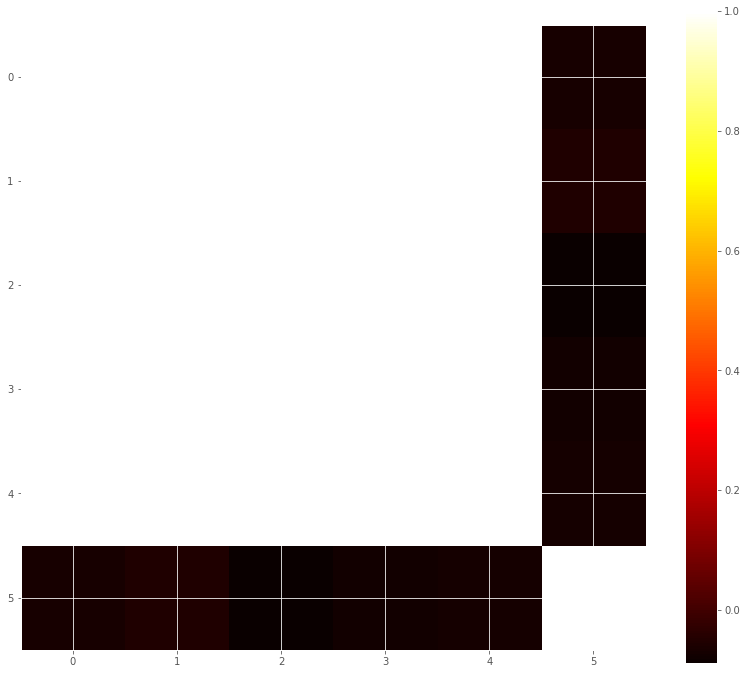

In [234]:
#Setting Graph Size
mpl.rc('figure', figsize=(14, 12))
mpl.__version__

plt.imshow(df.corr(), cmap='hot', interpolation='none')
plt.colorbar()

Exploring Moving Average

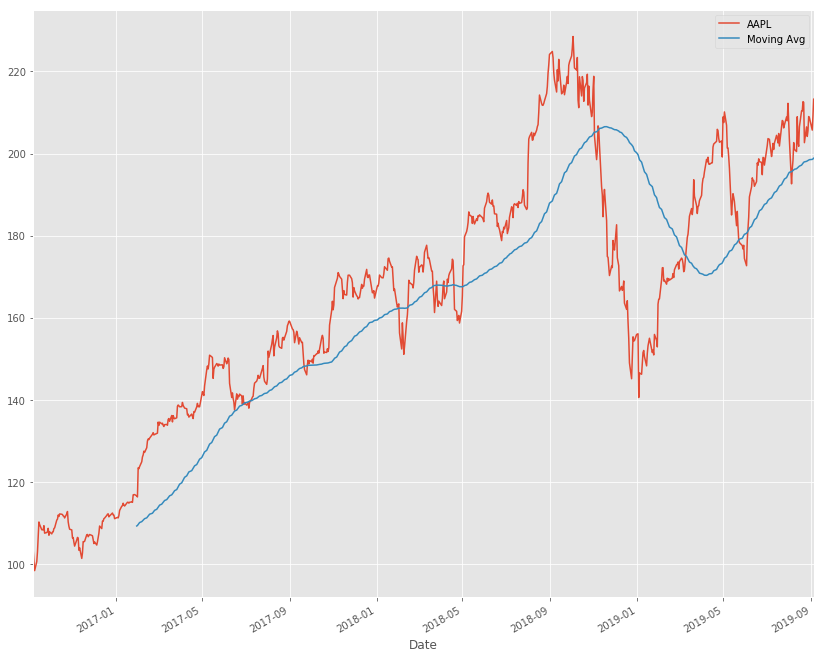

In [235]:
# Adjusting the style of matplotlib
style.use('ggplot')
close_px.plot(label='AAPL')    #Replace with stock name 
mavg.plot(label='Moving Avg')
plt.legend()

Set Features

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
last_date_record = dfreg.iloc[-1].name #Storing last date for plotting graph

In [238]:
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-30,208.740005,21143400,1.556961,-0.675675
2019-09-03,205.699997,20023000,1.341757,-0.353629
2019-09-04,209.190002,19188100,1.032549,0.383897
2019-09-05,213.279999,23913700,1.153416,0.603773
2019-09-06,213.259995,19350800,0.895622,-0.369076


In [0]:
# Drop missing value
import math
import numpy as np
from sklearn import preprocessing
dfreg.fillna(value=0, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

Import Scikit Learn dependencies for training the model

In [0]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [241]:
# Setting Test and Training Data
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Lasso Regression
clflasreg = linear_model.Lasso(alpha=0.1)
clflasreg.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#Logistic Regression
clfbay = linear_model.BayesianRidge()
clfbay.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencelassref = clflasreg.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidencbay = clfbay.score(X_test,y_test)


**Showing Confidence Score**

In [243]:
print(confidencereg)
print(confidencelassref)
print(confidencepoly3)
print(confidencbay)

0.9451859754045806
0.9448181071117937
0.9333444342120191
0.9451899505407497


Bayesian regression has the highest confidence

In [0]:
forecast_set_lin = clfreg.predict(X_lately)
forecast_set_las = clflasreg.predict(X_lately)
forecast_set_qua = clfpoly3.predict(X_lately)
forecast_set_bay = clfbay.predict(X_lately)
dfreg['Forecast'] = np.nan           # Marking past forecast value as NaN and we will be calculating future value for next 8 records (Ceil of 1% of 755 records)

In [245]:
print('Values for Linear Regression ' + str(forecast_set_lin))
print('Values for Lasso Regression ' + str(forecast_set_las))
print('Values for Quadratic Regression ' + str(forecast_set_qua))
print('Values for Bayesian Regression ' + str(forecast_set_bay))

Values for Linear Regression [204.64925873 205.8588526  208.91971216 208.87787238 205.91699702
 209.10726286 212.70486434 213.02719582]
Values for Lasso Regression [204.10590333 205.68923716 208.78697471 208.58471724 205.6936056
 209.01661963 212.6983723  212.90871667]
Values for Quadratic Regression [208.46982266 208.14660427 209.92813032 211.7689271  208.10169489
 209.81076792 212.08197054 213.84946544]
Values for Bayesian Regression [204.63522824 205.84075123 208.8992199  208.85868395 205.89849248
 209.08597961 212.68118529 213.0031968 ]


**Stock Price using Bayesian Regression as it as highest confidence**

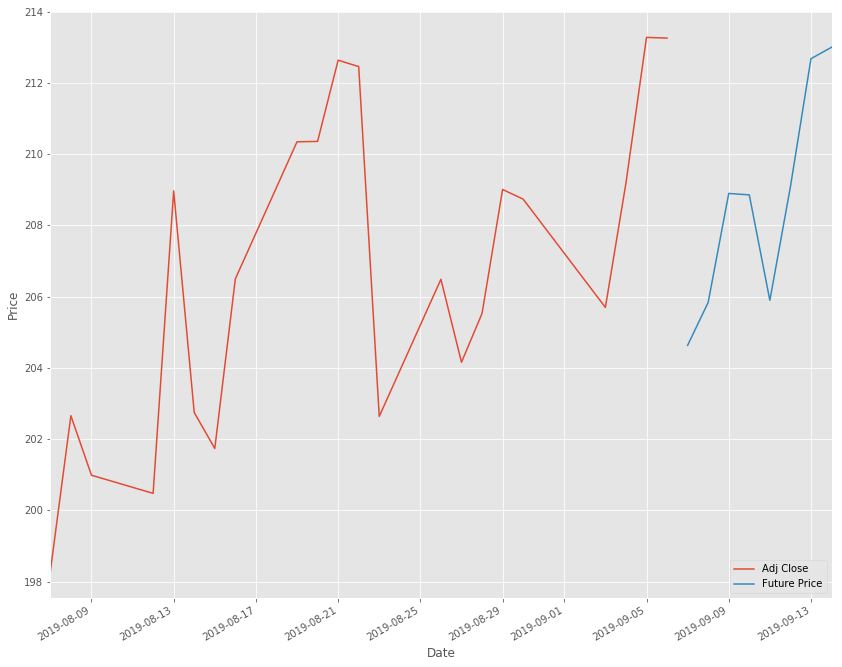

In [247]:
last_date = last_date_record
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_bay:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

#Showing last 30 data points
dfreg['Adj Close'].tail(30).plot()
dfreg['Forecast'].tail(30).plot(label='Future Price')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [248]:
dfreg.tail(10) #Showing stock price data

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2019-09-05,213.279999,23913700.0,1.153416,0.603773,NaN,NaN
2019-09-06,213.259995,19350800.0,0.895622,-0.369076,NaN,NaN
2019-09-07,NaN,NaN,NaN,NaN,NaN,204.635228
2019-09-08,NaN,NaN,NaN,NaN,NaN,205.840751
2019-09-09,NaN,NaN,NaN,NaN,NaN,208.899220
2019-09-10,NaN,NaN,NaN,NaN,NaN,208.858684
2019-09-11,NaN,NaN,NaN,NaN,NaN,205.898492
2019-09-12,NaN,NaN,NaN,NaN,NaN,209.085980
2019-09-13,NaN,NaN,NaN,NaN,NaN,212.681185
